In [28]:
# use gpu
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# prepare dataset
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='data/mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = datasets.MNIST(root='data/mnist/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

#design model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=5,padding=2)
        self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=5,padding=2)
        self.pooling = torch.nn.MaxPool2d(2)
        self.fc = torch.nn.Linear(288, 10) # 32*3*3
# 第一次先把注释内的代码取消注释，并把 x = self.fc(x)注释掉，
# 在最后输出的结果内讲self.fc第一个参数填上去（如最后一个xsize为[64,120]，就填120，
# 因为第一个数据值是batch_size）     
    def forward(self, x):
        batch_size = x.size(0)
        x = F.relu(self.pooling(self.conv1(x)))
#         print(x.size())
        x = F.relu(self.pooling(self.conv2(x)))
#         print(x.size())
        x = F.relu(self.pooling(self.conv3(x)))
#         print(x.size())
        x = x.view(batch_size, -1)
#         print(x.size())
        x = self.fc(x)
        return x

model = Net()
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=288, out_features=10, bias=True)
)

In [29]:
# construct loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# training cycle forward, backward, update
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss/300))
            running_loss = 0.0

def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('accuracy on test set: %d %%' % (100*correct/total))
    return correct/total

[1,   300] loss: 1.213
[1,   600] loss: 0.202
[1,   900] loss: 0.137
accuracy on test set: 96 %
[2,   300] loss: 0.107
[2,   600] loss: 0.088
[2,   900] loss: 0.079
accuracy on test set: 97 %
[3,   300] loss: 0.072
[3,   600] loss: 0.067
[3,   900] loss: 0.061
accuracy on test set: 97 %
[4,   300] loss: 0.057
[4,   600] loss: 0.050
[4,   900] loss: 0.056
accuracy on test set: 98 %
[5,   300] loss: 0.049
[5,   600] loss: 0.043
[5,   900] loss: 0.045
accuracy on test set: 98 %
[6,   300] loss: 0.037
[6,   600] loss: 0.040
[6,   900] loss: 0.040
accuracy on test set: 98 %
[7,   300] loss: 0.031
[7,   600] loss: 0.038
[7,   900] loss: 0.035
accuracy on test set: 98 %
[8,   300] loss: 0.031
[8,   600] loss: 0.030
[8,   900] loss: 0.032
accuracy on test set: 98 %
[9,   300] loss: 0.027
[9,   600] loss: 0.027
[9,   900] loss: 0.031
accuracy on test set: 98 %
[10,   300] loss: 0.025
[10,   600] loss: 0.025
[10,   900] loss: 0.027
accuracy on test set: 99 %


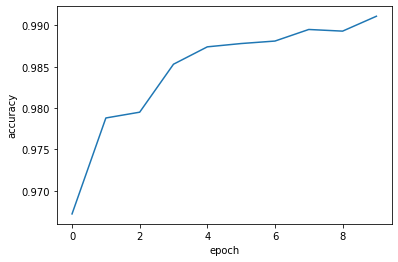

In [30]:
epoch_list = []
acc_list = []

for epoch in range(10):
    train(epoch)
    acc = test()
    epoch_list.append(epoch)
    acc_list.append(acc)
    
plt.plot(epoch_list, acc_list)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()